# Código do KNN

## Imports

In [1]:
from functools import reduce
import numpy as np
import numpy.linalg as LA
import math

## Classe KNN

In [68]:
class KNN:
    @staticmethod
    def BLOCK_DISTANCE(a, b):
        '''Or distance of Manhattan. Considers only movements in axis directions.'''
        return np.sum(np.absolute(a-b))

    @staticmethod
    def EUCLIDEAN_DISTANCE(a, b):
        '''The shortest route between two points.'''
        return LA.norm(a-b)

    @staticmethod
    def NO_WEIGHT(acc, i):
        '''Just counts the frequency of every label.'''
        (label, _) = i
        acc[label] += 1
        return acc

    @staticmethod
    def WEIGHTED(acc, i):
        '''Weights the values by their distance.'''
        (label, distance) = i
        acc[label] += 1 / (distance ** 2) if distance else math.inf
        return acc

    def __init__(self, distance = None, k = 3, weight = None, adaptive = False):
        self.samples = []
        self.distance = KNN.EUCLIDEAN_DISTANCE if distance == None else distance
        self.k = k
        self.weight = KNN.NO_WEIGHT if weight == None else weight
        self.adaptive = adaptive
    
    def calculateRadius(self, sample):
        '''Calculates the radius for the adaptive distance.
        If the distance for the classification is changed this function should be called again.'''
        distances = [self.distance(sample[0:-1], s[0:-1]) for s in self.samples if s[-1] != sample[-1]]
        return min(distances)

    def train(self, training):
        '''Trains the kNN.'''
        self.samples = training
        self.sampleRadius = [self.calculateRadius(i) for i in self.samples]

    def classify(self, sample):
        '''Classifies a single sample.'''
        closest = self.find_closest(sample)
        votes = reduce(self.weight, closest, {i[-1]: 0 for i in self.samples})
        chosen = max(votes.keys(), key = lambda i: votes[i])
        return chosen

    def test(self, testSamples):
        '''Tests the kNN efficiency in classifying its samples.'''
        realResults = [i[-1] for i in testSamples]
        testResults = [self.classify(i) for i in testSamples]
        matched = [a == b for (a, b) in zip(realResults, testResults)]
        classMatched = {i: list(zip(realResults, matched)).count((i, True)) / realResults.count(i) for i in realResults}
        return {
            "hitRate": matched.count(True) / len(realResults),
            "missRate": matched.count(False) / len(realResults),
            "classHits": classMatched
        }

    def find_closest(self, sample):
        '''Finds the closest k samples.'''
        if self.adaptive:
            distances = [(s[-1], self.distance(sample[0:-1], s[0:-1]) / self.sampleRadius[i]\
                        if self.sampleRadius[i] else math.inf) for (i, s) in enumerate(self.samples)]
        else:
            distances = [(s[-1], self.distance(sample[0:-1], s[0:-1])) for s in self.samples]
        distances.sort(key = lambda i: i[1])
        return distances[0:self.k]

# Avaliações

## Imports

In [3]:
%matplotlib inline

from scipy.io import arff
import pandas as pd
from time import process_time

import matplotlib
import matplotlib.pyplot as plt
from statistics import mean

## Funções p/ o experimento

In [72]:
# Number of folds to be generated
k = 5
def k_fold(sepSamples, k):
    ''''Splits the samples in k groups with similar amounts of samples and distributions of every class.'''
    folds = [[] for _ in range(k)]
    for i in sepSamples:
        splitClass = np.array_split(sepSamples[i], k)
        [a.extend(b) for (a, b) in zip(folds, splitClass)]
    return folds

In [73]:
def cross_validation(knn, folds):
    '''Evaluates a knn configuration through cross validation.'''
    hitRates = []
    classHits = []
    trainTimes = []
    testTimes = []
    for i in range(len(folds)):
        print("Testing on fold " + str(i))
        train = [s for j, fold in enumerate(folds) if i != j for s in fold]
        test = folds[i]

        trainTimes.append(process_time())
        knn.train(train)
        trainTimes[-1] = process_time() - trainTimes[-1]

        testTimes.append(process_time())
        testResults = knn.test(test)
        testTimes[-1] = process_time() - testTimes[-1]

        hitRates.append(testResults['hitRate'])
        classHits.append(testResults['classHits'])
    return {'hitRates': hitRates, 'classHits': classHits, 'trainTimes': trainTimes, 'testTimes': testTimes}

In [74]:
kVariations = [1, 2, 3, 5, 7, 9, 11, 13, 15]
def experiment(knn, kVariations, folds):
    '''The code which will run the experiment.'''
    result = {}
    for i in kVariations:
        print('Parameter k = ' + str(i))
        knn.k = i
        result[i] = cross_validation(knn, folds)
    return result

## Base de Dados 1 - CM1

### Preparação

In [75]:
data = arff.loadarff('Datasets/cm1.arff')
dataFrame = pd.DataFrame(data[0])
dataFrame.defects = [1 if i == b'true' else 0 for i in dataFrame.defects]
rawData = dataFrame.values
rawData

array([[   1.1,    1.4,    1.4, ...,    1.2,    1.4,    0. ],
       [   1. ,    1. ,    1. , ...,    1. ,    1. ,    1. ],
       [  24. ,    5. ,    1. , ...,   19. ,    9. ,    0. ],
       ..., 
       [  82. ,   11. ,    3. , ...,  190. ,   21. ,    1. ],
       [  10. ,    2. ,    1. , ...,   13. ,    3. ,    1. ],
       [  28. ,    6. ,    5. , ...,   37. ,   11. ,    1. ]])

In [76]:
# Separating samples by class
classes = {i[-1]: rawData[np.where(rawData[:,-1] == i[-1])] for i in rawData}
classes

{0.0: array([[  1.1,   1.4,   1.4, ...,   1.2,   1.4,   0. ],
        [ 24. ,   5. ,   1. , ...,  19. ,   9. ,   0. ],
        [ 20. ,   4. ,   4. , ...,  16. ,   7. ,   0. ],
        ..., 
        [  4. ,   1. ,   1. , ...,   6. ,   1. ,   0. ],
        [  3. ,   1. ,   1. , ...,   2. ,   1. ,   0. ],
        [ 12. ,   3. ,   1. , ...,  25. ,   5. ,   0. ]]),
 1.0: array([[   1.,    1.,    1., ...,    1.,    1.,    1.],
        [  31.,    4.,    1., ...,   51.,    7.,    1.],
        [  29.,    5.,    1., ...,   37.,    9.,    1.],
        ..., 
        [  82.,   11.,    3., ...,  190.,   21.,    1.],
        [  10.,    2.,    1., ...,   13.,    3.,    1.],
        [  28.,    6.,    5., ...,   37.,   11.,    1.]])}

In [77]:
# Separating the folds
folds = k_fold(classes, k)

### KNN sem peso

In [85]:
weightlessKNN = KNN(weight=KNN.NO_WEIGHT, adaptive=False)
weightless = experiment(weightlessKNN, kVariations, folds, 42)
weightless

Parameter k = 1
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 2
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 7
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 9
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 11
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 13
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 15
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4


{1: {'classHits': [{0.0: 0.9222222222222223, 1.0: 0.4},
   {0.0: 0.9, 1.0: 0.3},
   {0.0: 0.9333333333333333, 1.0: 0.2},
   {0.0: 0.8666666666666667, 1.0: 0.1},
   {0.0: 0.9438202247191011, 1.0: 0.1111111111111111}],
  'hitRates': [0.87, 0.84, 0.86, 0.79, 0.8673469387755102],
  'testTimes': [0.34375, 0.328125, 0.3125, 0.328125, 0.3125],
  'trainTimes': [0.328125, 0.296875, 0.25, 0.265625, 0.265625]},
 2: {'classHits': [{0.0: 0.9888888888888889, 1.0: 0.1},
   {0.0: 0.9777777777777777, 1.0: 0.0},
   {0.0: 0.9777777777777777, 1.0: 0.0},
   {0.0: 0.9666666666666667, 1.0: 0.0},
   {0.0: 0.8314606741573034, 1.0: 0.4444444444444444}],
  'hitRates': [0.9, 0.88, 0.88, 0.87, 0.7959183673469388],
  'testTimes': [0.3125, 0.359375, 0.328125, 0.390625, 0.3125],
  'trainTimes': [0.25, 0.28125, 0.25, 0.25, 0.28125]},
 3: {'classHits': [{0.0: 0.9444444444444444, 1.0: 0.2},
   {0.0: 0.9666666666666667, 1.0: 0.0},
   {0.0: 0.9666666666666667, 1.0: 0.0},
   {0.0: 0.9333333333333333, 1.0: 0.1},
   {0.0: 0.

### KNN com peso

In [86]:
weightedKNN = KNN(weight=KNN.WEIGHTED, adaptive=False)
weighted = experiment(weightedKNN, kVariations, folds, 42)
weighted

Parameter k = 1
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 2
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 7
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 9
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 11
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 13
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 15
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4


{1: {'classHits': [{0.0: 0.9222222222222223, 1.0: 0.4},
   {0.0: 0.9, 1.0: 0.3},
   {0.0: 0.9333333333333333, 1.0: 0.2},
   {0.0: 0.8666666666666667, 1.0: 0.1},
   {0.0: 0.9438202247191011, 1.0: 0.1111111111111111}],
  'hitRates': [0.87, 0.84, 0.86, 0.79, 0.8673469387755102],
  'testTimes': [0.390625, 0.359375, 0.34375, 0.34375, 0.34375],
  'trainTimes': [0.5, 0.25, 0.25, 0.25, 0.28125]},
 2: {'classHits': [{0.0: 0.9222222222222223, 1.0: 0.4},
   {0.0: 0.9, 1.0: 0.3},
   {0.0: 0.9333333333333333, 1.0: 0.2},
   {0.0: 0.8666666666666667, 1.0: 0.1},
   {0.0: 0.9438202247191011, 1.0: 0.1111111111111111}],
  'hitRates': [0.87, 0.84, 0.86, 0.79, 0.8673469387755102],
  'testTimes': [0.34375, 0.359375, 0.34375, 0.359375, 0.453125],
  'trainTimes': [0.265625, 0.25, 0.25, 0.265625, 0.234375]},
 3: {'classHits': [{0.0: 0.9111111111111111, 1.0: 0.4},
   {0.0: 0.9222222222222223, 1.0: 0.3},
   {0.0: 0.9333333333333333, 1.0: 0.2},
   {0.0: 0.9111111111111111, 1.0: 0.1},
   {0.0: 0.9550561797752809, 

### KNN adaptativo sem peso

In [87]:
adaptiveKNN = KNN(weight=KNN.NO_WEIGHT, adaptive=True)
adaptive = experiment(adaptiveKNN, kVariations, folds, 42)
adaptive

Parameter k = 1
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 2
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 7
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 9
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 11
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 13
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 15
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4


{1: {'classHits': [{0.0: 0.9555555555555556, 1.0: 0.4},
   {0.0: 0.9333333333333333, 1.0: 0.3},
   {0.0: 0.9444444444444444, 1.0: 0.2},
   {0.0: 0.8777777777777778, 1.0: 0.1},
   {0.0: 0.9887640449438202, 1.0: 0.1111111111111111}],
  'hitRates': [0.9, 0.87, 0.87, 0.8, 0.9081632653061225],
  'testTimes': [0.359375, 0.390625, 0.453125, 0.34375, 0.4375],
  'trainTimes': [0.265625, 0.25, 0.25, 0.3125, 0.296875]},
 2: {'classHits': [{0.0: 1.0, 1.0: 0.0},
   {0.0: 0.9888888888888889, 1.0: 0.0},
   {0.0: 0.9666666666666667, 1.0: 0.0},
   {0.0: 0.9777777777777777, 1.0: 0.0},
   {0.0: 0.9775280898876404, 1.0: 0.2222222222222222}],
  'hitRates': [0.9, 0.89, 0.87, 0.88, 0.9081632653061225],
  'testTimes': [0.46875, 0.328125, 0.375, 0.359375, 0.390625],
  'trainTimes': [0.328125, 0.359375, 0.265625, 0.265625, 0.265625]},
 3: {'classHits': [{0.0: 0.9777777777777777, 1.0: 0.0},
   {0.0: 0.9888888888888889, 1.0: 0.0},
   {0.0: 0.9666666666666667, 1.0: 0.0},
   {0.0: 0.9555555555555556, 1.0: 0.0},
   

### Gráficos

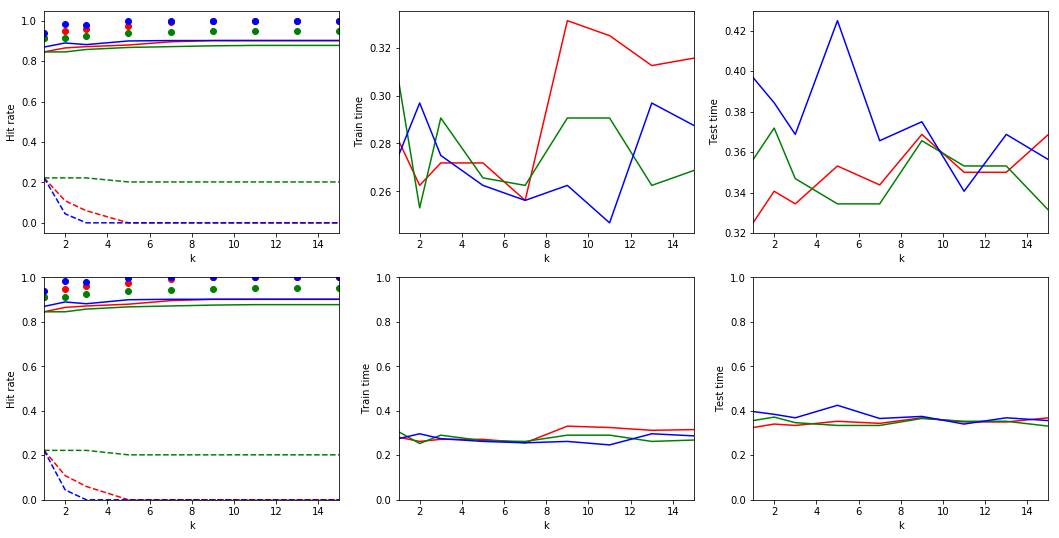

In [90]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

# Plotting
axes[0,0].plot(kVariations, [mean(weightless[i]['hitRates']) for i in weightless], 'r')
axes[0,0].plot(kVariations, [mean([a[0] for a in weightless[i]['classHits']]) for i in weightless], 'ro')
axes[0,0].plot(kVariations, [mean([a[1] for a in weightless[i]['classHits']]) for i in weightless], 'r--')
axes[0,0].plot(kVariations, [mean(weighted[i]['hitRates']) for i in weightless], 'g')
axes[0,0].plot(kVariations, [mean([a[0] for a in weighted[i]['classHits']]) for i in weighted], 'go')
axes[0,0].plot(kVariations, [mean([a[1] for a in weighted[i]['classHits']]) for i in weighted], 'g--')
axes[0,0].plot(kVariations, [mean(adaptive[i]['hitRates']) for i in weightless], 'b')
axes[0,0].plot(kVariations, [mean([a[0] for a in adaptive[i]['classHits']]) for i in adaptive], 'bo')
axes[0,0].plot(kVariations, [mean([a[1] for a in adaptive[i]['classHits']]) for i in adaptive], 'b--')

axes[1,0].plot(kVariations, [mean(weightless[i]['hitRates']) for i in weightless], 'r')
axes[1,0].plot(kVariations, [mean([a[0] for a in weightless[i]['classHits']]) for i in weightless], 'ro')
axes[1,0].plot(kVariations, [mean([a[1] for a in weightless[i]['classHits']]) for i in weightless], 'r--')
axes[1,0].plot(kVariations, [mean(weighted[i]['hitRates']) for i in weightless], 'g')
axes[1,0].plot(kVariations, [mean([a[0] for a in weighted[i]['classHits']]) for i in weighted], 'go')
axes[1,0].plot(kVariations, [mean([a[1] for a in weighted[i]['classHits']]) for i in weighted], 'g--')
axes[1,0].plot(kVariations, [mean(adaptive[i]['hitRates']) for i in weightless], 'b')
axes[1,0].plot(kVariations, [mean([a[0] for a in adaptive[i]['classHits']]) for i in adaptive], 'bo')
axes[1,0].plot(kVariations, [mean([a[1] for a in adaptive[i]['classHits']]) for i in adaptive], 'b--')

axes[0,1].plot(kVariations, [mean(weightless[i]['trainTimes']) for i in weightless], 'r')
axes[0,1].plot(kVariations, [mean(weighted[i]['trainTimes']) for i in weightless], 'g')
axes[0,1].plot(kVariations, [mean(adaptive[i]['trainTimes']) for i in weightless], 'b')
axes[1,1].plot(kVariations, [mean(weightless[i]['trainTimes']) for i in weightless], 'r')
axes[1,1].plot(kVariations, [mean(weighted[i]['trainTimes']) for i in weightless], 'g')
axes[1,1].plot(kVariations, [mean(adaptive[i]['trainTimes']) for i in weightless], 'b')

axes[0,2].plot(kVariations, [mean(weightless[i]['testTimes']) for i in weightless], 'r')
axes[0,2].plot(kVariations, [mean(weighted[i]['testTimes']) for i in weightless], 'g')
axes[0,2].plot(kVariations, [mean(adaptive[i]['testTimes']) for i in weightless], 'b')
axes[1,2].plot(kVariations, [mean(weightless[i]['testTimes']) for i in weightless], 'r')
axes[1,2].plot(kVariations, [mean(weighted[i]['testTimes']) for i in weightless], 'g')
axes[1,2].plot(kVariations, [mean(adaptive[i]['testTimes']) for i in weightless], 'b')

# Setting labels and scales
[i.set_xlim(1, 15) for row in axes for i in row]
[i.set_xlabel('k') for row in axes for i in row]

axes[0,0].set_ylabel('Hit rate')
axes[1,0].set_ylim(0, 1)
axes[1,0].set_ylabel('Hit rate')

axes[0,1].set_ylabel('Train time')
axes[1,1].set_ylim(0, 1)
axes[1,1].set_ylabel('Train time')

axes[0,2].set_ylabel('Test time')
axes[1,2].set_ylim(0, 1)
axes[1,2].set_ylabel('Test time')

plt.show()

## Base de Dados 2 - KC1

In [96]:
data = arff.loadarff('Datasets/kc1.arff')
dataFrame = pd.DataFrame(data[0])
dataFrame.defects = [1 if i == b'true' else 0 for i in dataFrame.defects]
rawData = dataFrame.values
rawData

array([[  1.1,   1.4,   1.4, ...,   1.2,   1.4,   0. ],
       [  1. ,   1. ,   1. , ...,   1. ,   1. ,   1. ],
       [ 83. ,  11. ,   1. , ...,  64. ,  21. ,   1. ],
       ..., 
       [  2. ,   1. ,   1. , ...,   1. ,   1. ,   0. ],
       [ 13. ,   1. ,   1. , ...,   8. ,   1. ,   0. ],
       [ 11. ,   2. ,   1. , ...,   9. ,   3. ,   0. ]])

In [97]:
# Separating samples by class
classes = {i[-1]: rawData[np.where(rawData[:,-1] == i[-1])] for i in rawData}
classes

{0.0: array([[  1.1,   1.4,   1.4, ...,   1.2,   1.4,   0. ],
        [  5. ,   1. ,   1. , ...,   4. ,   1. ,   0. ],
        [  3. ,   1. ,   1. , ...,   0. ,   1. ,   0. ],
        ..., 
        [  2. ,   1. ,   1. , ...,   1. ,   1. ,   0. ],
        [ 13. ,   1. ,   1. , ...,   8. ,   1. ,   0. ],
        [ 11. ,   2. ,   1. , ...,   9. ,   3. ,   0. ]]),
 1.0: array([[   1.,    1.,    1., ...,    1.,    1.,    1.],
        [  83.,   11.,    1., ...,   64.,   21.,    1.],
        [  46.,    8.,    6., ...,   52.,   15.,    1.],
        ..., 
        [  35.,    5.,    5., ...,   34.,    9.,    1.],
        [ 116.,   12.,    6., ...,  140.,   23.,    1.],
        [ 205.,   26.,   16., ...,  194.,   51.,    1.]])}

In [98]:
# Separating the folds
folds = k_fold(classes, k)

### KNN sem peso

In [99]:
weightlessKNN = KNN(weight=KNN.NO_WEIGHT, adaptive=False)
weightless = experiment(weightlessKNN, kVariations, folds, 42)
weightless

Parameter k = 1
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 2
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 7
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 9
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 11
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 13
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 15
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4


{1: {'classHits': [{0.0: 0.8403361344537815, 1.0: 0.24242424242424243},
   {0.0: 0.9019607843137255, 1.0: 0.3230769230769231},
   {0.0: 0.7955182072829131, 1.0: 0.3384615384615385},
   {0.0: 0.8735955056179775, 1.0: 0.26153846153846155},
   {0.0: 0.9185393258426966, 1.0: 0.3230769230769231}],
  'hitRates': [0.7470449172576832,
   0.8127962085308057,
   0.7251184834123223,
   0.7790973871733967,
   0.8266033254156769],
  'testTimes': [5.78125, 6.234375, 6.25, 5.75, 5.75],
  'trainTimes': [6.3125, 6.25, 6.78125, 6.21875, 6.046875]},
 2: {'classHits': [{0.0: 0.9663865546218487, 1.0: 0.045454545454545456},
   {0.0: 0.969187675070028, 1.0: 0.07692307692307693},
   {0.0: 0.907563025210084, 1.0: 0.16923076923076924},
   {0.0: 0.949438202247191, 1.0: 0.06153846153846154},
   {0.0: 0.8258426966292135, 1.0: 0.5538461538461539}],
  'hitRates': [0.8226950354609929,
   0.8317535545023697,
   0.7938388625592417,
   0.8123515439429929,
   0.7838479809976246],
  'testTimes': [5.921875, 5.859375, 5.843

### KNN com peso

In [100]:
weightedKNN = KNN(weight=KNN.WEIGHTED, adaptive=False)
weighted = experiment(weightedKNN, kVariations, folds, 42)
weighted

Parameter k = 1
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 2
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 7
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 9
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 11
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 13
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 15
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4


{1: {'classHits': [{0.0: 0.8403361344537815, 1.0: 0.24242424242424243},
   {0.0: 0.9019607843137255, 1.0: 0.3230769230769231},
   {0.0: 0.7955182072829131, 1.0: 0.3384615384615385},
   {0.0: 0.8735955056179775, 1.0: 0.26153846153846155},
   {0.0: 0.9185393258426966, 1.0: 0.3230769230769231}],
  'hitRates': [0.7470449172576832,
   0.8127962085308057,
   0.7251184834123223,
   0.7790973871733967,
   0.8266033254156769],
  'testTimes': [5.9375, 5.75, 5.71875, 5.875, 5.734375],
  'trainTimes': [6.109375, 6.171875, 6.140625, 6.03125, 6.09375]},
 2: {'classHits': [{0.0: 0.8403361344537815, 1.0: 0.24242424242424243},
   {0.0: 0.9019607843137255, 1.0: 0.3230769230769231},
   {0.0: 0.8151260504201681, 1.0: 0.3230769230769231},
   {0.0: 0.8735955056179775, 1.0: 0.26153846153846155},
   {0.0: 0.9101123595505618, 1.0: 0.3230769230769231}],
  'hitRates': [0.7470449172576832,
   0.8127962085308057,
   0.7393364928909952,
   0.7790973871733967,
   0.8194774346793349],
  'testTimes': [5.84375, 5.82812

### KNN adaptativo sem peso

In [101]:
adaptiveKNN = KNN(weight=KNN.NO_WEIGHT, adaptive=True)
adaptive = experiment(adaptiveKNN, kVariations, folds, 42)
adaptive

Parameter k = 1
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 2
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 7
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 9
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 11
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 13
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Parameter k = 15
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4


{1: {'classHits': [{0.0: 0.8515406162464986, 1.0: 0.24242424242424243},
   {0.0: 0.9187675070028011, 1.0: 0.23076923076923078},
   {0.0: 0.84593837535014, 1.0: 0.3384615384615385},
   {0.0: 0.8904494382022472, 1.0: 0.23076923076923078},
   {0.0: 0.9550561797752809, 1.0: 0.24615384615384617}],
  'hitRates': [0.7565011820330969,
   0.8127962085308057,
   0.7677725118483413,
   0.7885985748218527,
   0.8456057007125891],
  'testTimes': [5.5625, 5.453125, 6.125, 6.015625, 6.03125],
  'trainTimes': [6.03125, 6.015625, 6.5, 6.015625, 6.375]},
 2: {'classHits': [{0.0: 0.957983193277311, 1.0: 0.09090909090909091},
   {0.0: 0.9635854341736695, 1.0: 0.12307692307692308},
   {0.0: 0.9131652661064426, 1.0: 0.16923076923076924},
   {0.0: 0.9747191011235955, 1.0: 0.13846153846153847},
   {0.0: 0.9213483146067416, 1.0: 0.3076923076923077}],
  'hitRates': [0.8226950354609929,
   0.8341232227488151,
   0.7985781990521327,
   0.8456057007125891,
   0.8266033254156769],
  'testTimes': [5.65625, 5.515625,

### Gráficos

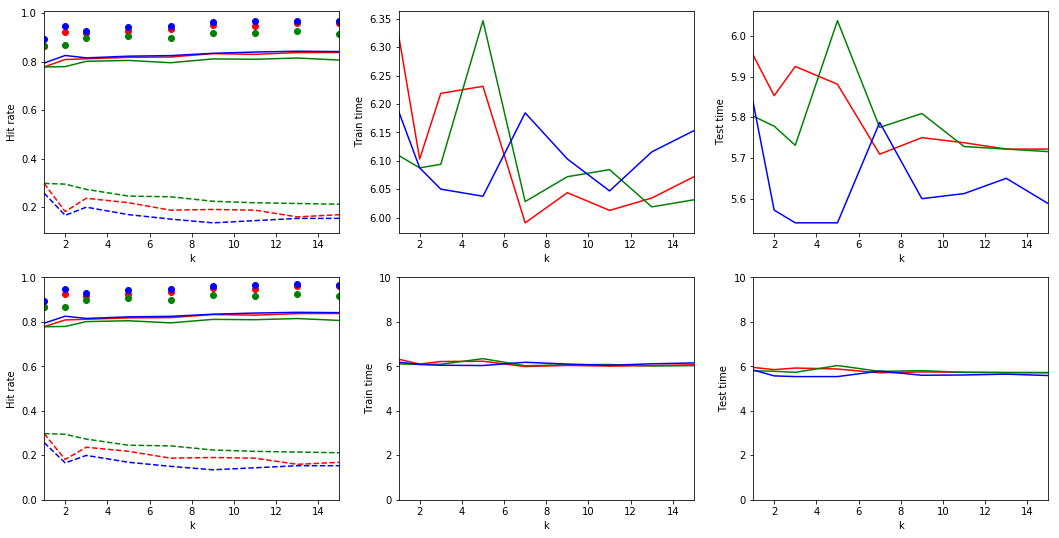

In [103]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

# Plotting
axes[0,0].plot(kVariations, [mean(weightless[i]['hitRates']) for i in weightless], 'r')
axes[0,0].plot(kVariations, [mean([a[0] for a in weightless[i]['classHits']]) for i in weightless], 'ro')
axes[0,0].plot(kVariations, [mean([a[1] for a in weightless[i]['classHits']]) for i in weightless], 'r--')
axes[0,0].plot(kVariations, [mean(weighted[i]['hitRates']) for i in weightless], 'g')
axes[0,0].plot(kVariations, [mean([a[0] for a in weighted[i]['classHits']]) for i in weighted], 'go')
axes[0,0].plot(kVariations, [mean([a[1] for a in weighted[i]['classHits']]) for i in weighted], 'g--')
axes[0,0].plot(kVariations, [mean(adaptive[i]['hitRates']) for i in weightless], 'b')
axes[0,0].plot(kVariations, [mean([a[0] for a in adaptive[i]['classHits']]) for i in adaptive], 'bo')
axes[0,0].plot(kVariations, [mean([a[1] for a in adaptive[i]['classHits']]) for i in adaptive], 'b--')

axes[1,0].plot(kVariations, [mean(weightless[i]['hitRates']) for i in weightless], 'r')
axes[1,0].plot(kVariations, [mean([a[0] for a in weightless[i]['classHits']]) for i in weightless], 'ro')
axes[1,0].plot(kVariations, [mean([a[1] for a in weightless[i]['classHits']]) for i in weightless], 'r--')
axes[1,0].plot(kVariations, [mean(weighted[i]['hitRates']) for i in weightless], 'g')
axes[1,0].plot(kVariations, [mean([a[0] for a in weighted[i]['classHits']]) for i in weighted], 'go')
axes[1,0].plot(kVariations, [mean([a[1] for a in weighted[i]['classHits']]) for i in weighted], 'g--')
axes[1,0].plot(kVariations, [mean(adaptive[i]['hitRates']) for i in weightless], 'b')
axes[1,0].plot(kVariations, [mean([a[0] for a in adaptive[i]['classHits']]) for i in adaptive], 'bo')
axes[1,0].plot(kVariations, [mean([a[1] for a in adaptive[i]['classHits']]) for i in adaptive], 'b--')

axes[0,1].plot(kVariations, [mean(weightless[i]['trainTimes']) for i in weightless], 'r')
axes[0,1].plot(kVariations, [mean(weighted[i]['trainTimes']) for i in weightless], 'g')
axes[0,1].plot(kVariations, [mean(adaptive[i]['trainTimes']) for i in weightless], 'b')
axes[1,1].plot(kVariations, [mean(weightless[i]['trainTimes']) for i in weightless], 'r')
axes[1,1].plot(kVariations, [mean(weighted[i]['trainTimes']) for i in weightless], 'g')
axes[1,1].plot(kVariations, [mean(adaptive[i]['trainTimes']) for i in weightless], 'b')

axes[0,2].plot(kVariations, [mean(weightless[i]['testTimes']) for i in weightless], 'r')
axes[0,2].plot(kVariations, [mean(weighted[i]['testTimes']) for i in weightless], 'g')
axes[0,2].plot(kVariations, [mean(adaptive[i]['testTimes']) for i in weightless], 'b')
axes[1,2].plot(kVariations, [mean(weightless[i]['testTimes']) for i in weightless], 'r')
axes[1,2].plot(kVariations, [mean(weighted[i]['testTimes']) for i in weightless], 'g')
axes[1,2].plot(kVariations, [mean(adaptive[i]['testTimes']) for i in weightless], 'b')

# Setting labels and scales
[i.set_xlim(1, 15) for row in axes for i in row]
[i.set_xlabel('k') for row in axes for i in row]

axes[0,0].set_ylabel('Hit rate')
axes[1,0].set_ylim(0, 1)
axes[1,0].set_ylabel('Hit rate')

axes[0,1].set_ylabel('Train time')
axes[1,1].set_ylim(0, 10)
axes[1,1].set_ylabel('Train time')

axes[0,2].set_ylabel('Test time')
axes[1,2].set_ylim(0, 10)
axes[1,2].set_ylabel('Test time')

plt.show()